# IMPORTING REQUIRED LIBRARIES.

In [106]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, completeness_score
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# LOADING THE VACCINATION TWEETS DATASET.

In [107]:
dt = pd.read_csv(r"C:\Machine Learning Python\vaccination_tweets.csv")
print(dt.head(10))

                    id             user_name                user_location  \
0  1340539111971516416            Rachel Roh    La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong            San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                     Your Bed   
3  1337855739918835717         Charles Adler       Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                          NaN   
5  1337852648389832708                   Dee          Birmingham, England   
6  1337851215875608579     Gunther Fehlinger  Austria, Ukraine and Kosovo   
7  1337850832256176136   Dr.Krutika Kuppalli                          NaN   
8  1337850023531347969           Erin Despas                          NaN   
9  1337842295857623042          Ch.Amjad Ali                    Islamabad   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46  

# CHECKING FOR ANY NULL VALUES.

In [108]:
print(dt.isna().sum())
print(dt.columns)

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64
Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')


# FUNCTION TO REMOVE URLs, Links, Special Characters FROM THE TEXT.

In [109]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+",'',text,flags=re.MULTILINE)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return ' '.join(filtered_text)
dt["text"] = dt['text'].apply(data_preprocessing)
text_dt = dt.drop_duplicates('text')

# REMOVING UNNECESSARY ATTRIBUTES.

In [110]:
text_dt = dt.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],axis=1)
print(text_dt.head(5))

                                                text
0  folks said daikon paste could treat cytokine s...
1  world wrong side history year hopefully bigges...
2  coronavirus sputnikv astrazeneca pfizerbiontec...
3  facts immutable senator even youre ethically s...
4  explain need vaccine borisjohnson matthancock ...


# STEMMING OR FINDING ROOT WORDS.

In [111]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data
text_dt['text'] = text_dt['text'].apply(stemming)
print(text_dt.head())

                                                text
0  folks said daikon paste could treat cytokine s...
1  world wrong side history year hopefully bigges...
2  coronavirus sputnikv astrazeneca pfizerbiontec...
3  facts immutable senator even youre ethically s...
4  explain need vaccine borisjohnson matthancock ...


# ASSIGNING POLARITY TO EVERY REVIEW.

In [112]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
text_dt['polarity'] = text_dt['text'].apply(polarity)
print(text_dt.head())

                                                text  polarity
0  folks said daikon paste could treat cytokine s...       0.0
1  world wrong side history year hopefully bigges...      -0.5
2  coronavirus sputnikv astrazeneca pfizerbiontec...       0.0
3  facts immutable senator even youre ethically s...       0.1
4  explain need vaccine borisjohnson matthancock ...       0.0


# ASSIGNING LABELS AS POSITIVE(polarity>0), NEGATIVE(polarity<0),NEUTRAL(polarity=0). 

In [113]:
def sentiment(label):
    if label<0:
        return "NEGATIVE"
    elif label==0:
        return "NEUTRAL"
    elif label>0:
        return "POSITIVE"

text_dt['sentiment'] = text_dt['polarity'].apply(sentiment)
print(text_dt.head())

                                                text  polarity sentiment
0  folks said daikon paste could treat cytokine s...       0.0   NEUTRAL
1  world wrong side history year hopefully bigges...      -0.5  NEGATIVE
2  coronavirus sputnikv astrazeneca pfizerbiontec...       0.0   NEUTRAL
3  facts immutable senator even youre ethically s...       0.1  POSITIVE
4  explain need vaccine borisjohnson matthancock ...       0.0   NEUTRAL


# PLOTTING MOST FREQUENT WORDS IN POSITIVE REVIEWS.

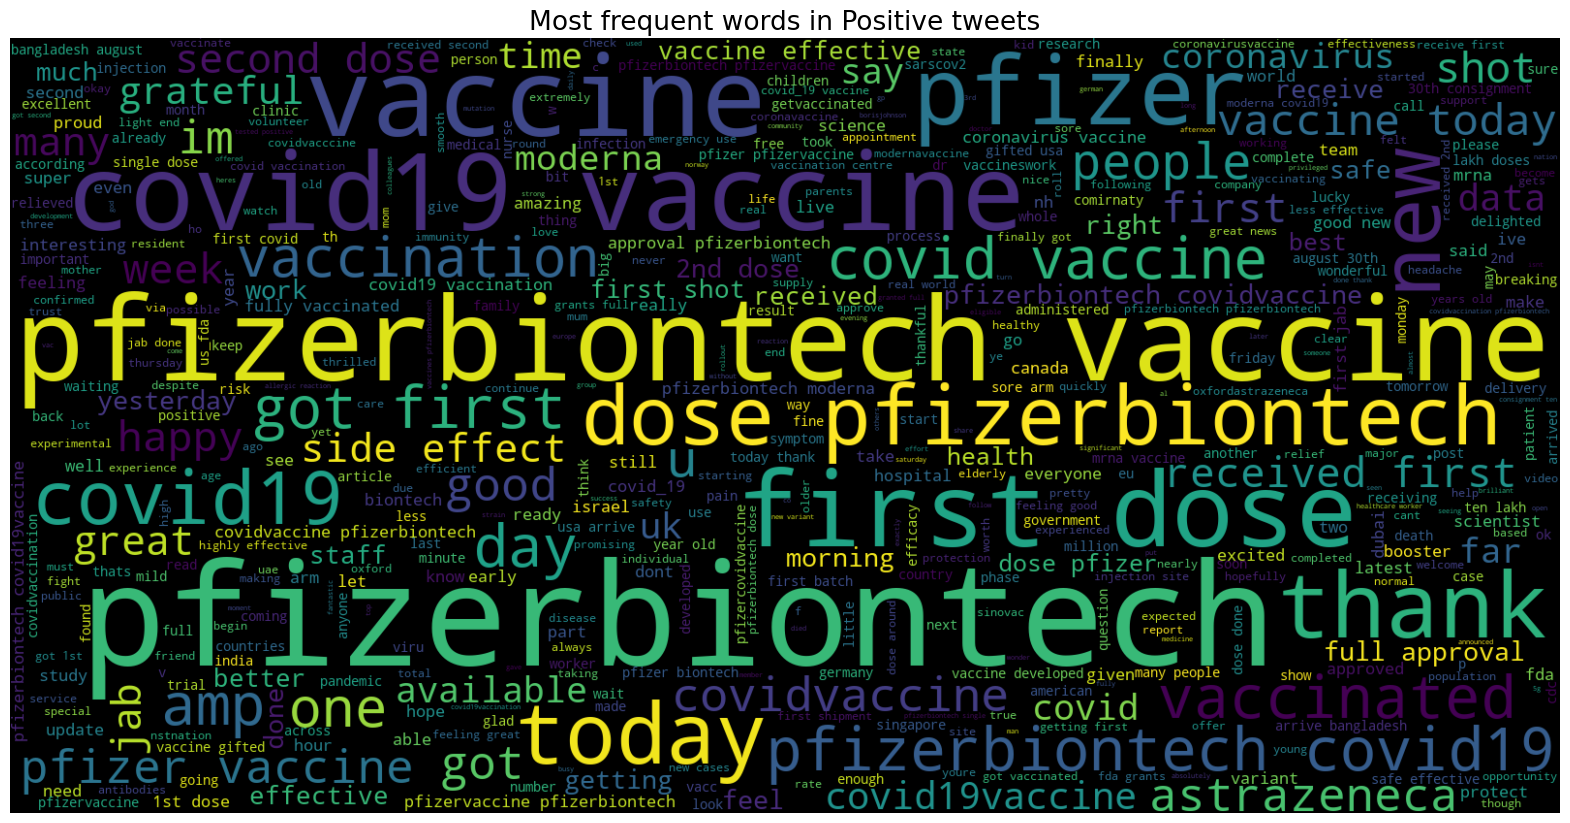

In [114]:
pos_tweets = text_dt[text_dt['sentiment']=='POSITIVE']
pos_tweets = pos_tweets.sort_values(['polarity'],ascending=False)
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor="None")
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Positive tweets',fontsize=19)
plt.show()

# PLOTTING MOST FREQUENT WORDS IN NEGATIVE REVIEWS.

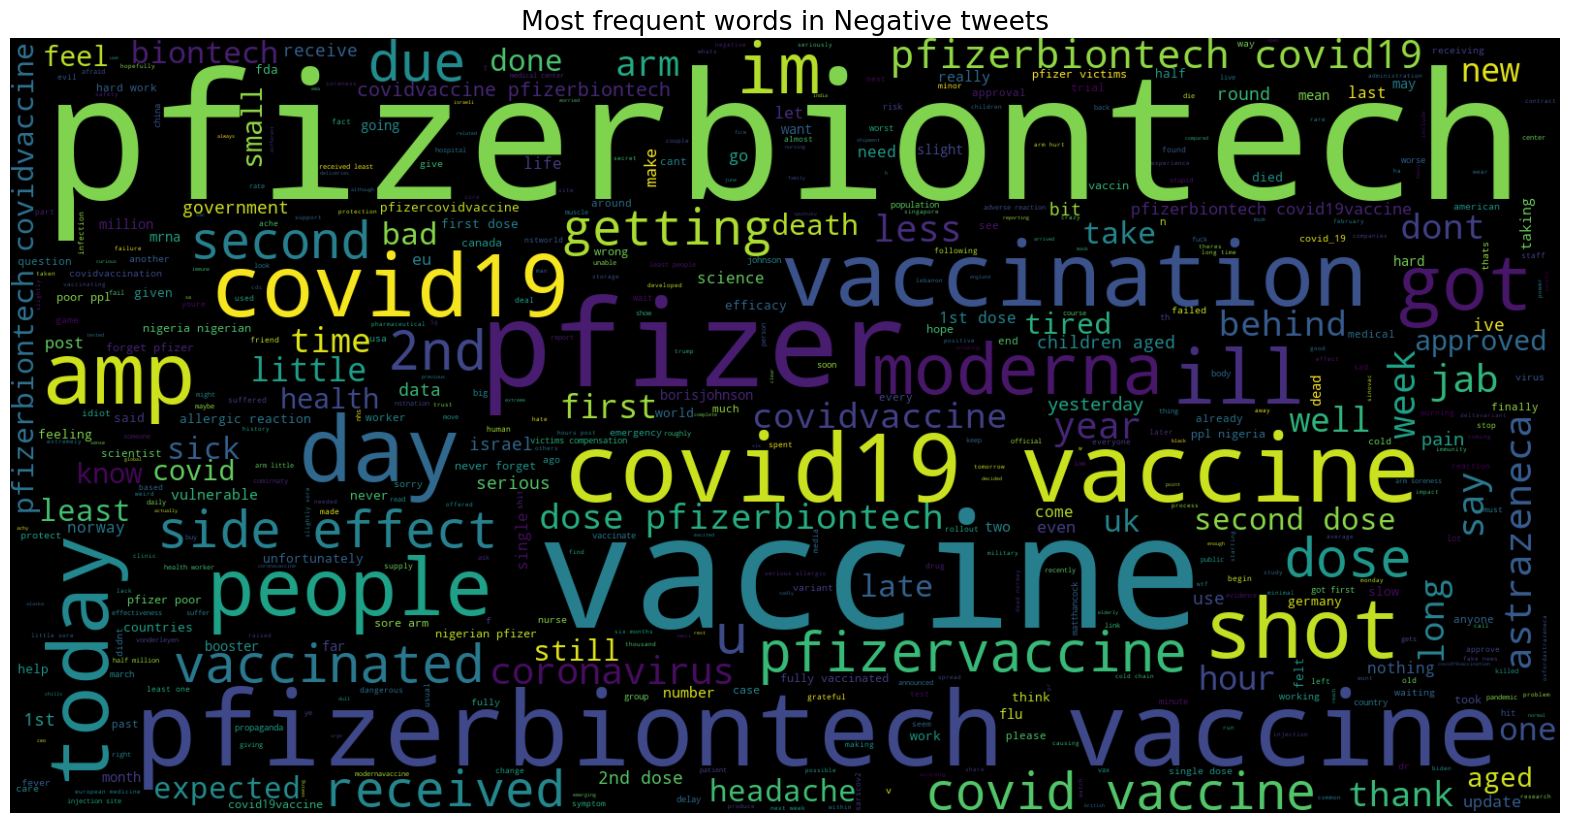

In [115]:
neg_tweets = text_dt[text_dt['sentiment']=='NEGATIVE']
neg_tweets = neg_tweets.sort_values(['polarity'],ascending=False)
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor="None")
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Negative tweets',fontsize=19)
plt.show()

# POTTING MOST FREQUENT WORDS IN NEUTRAL REVIEWS.

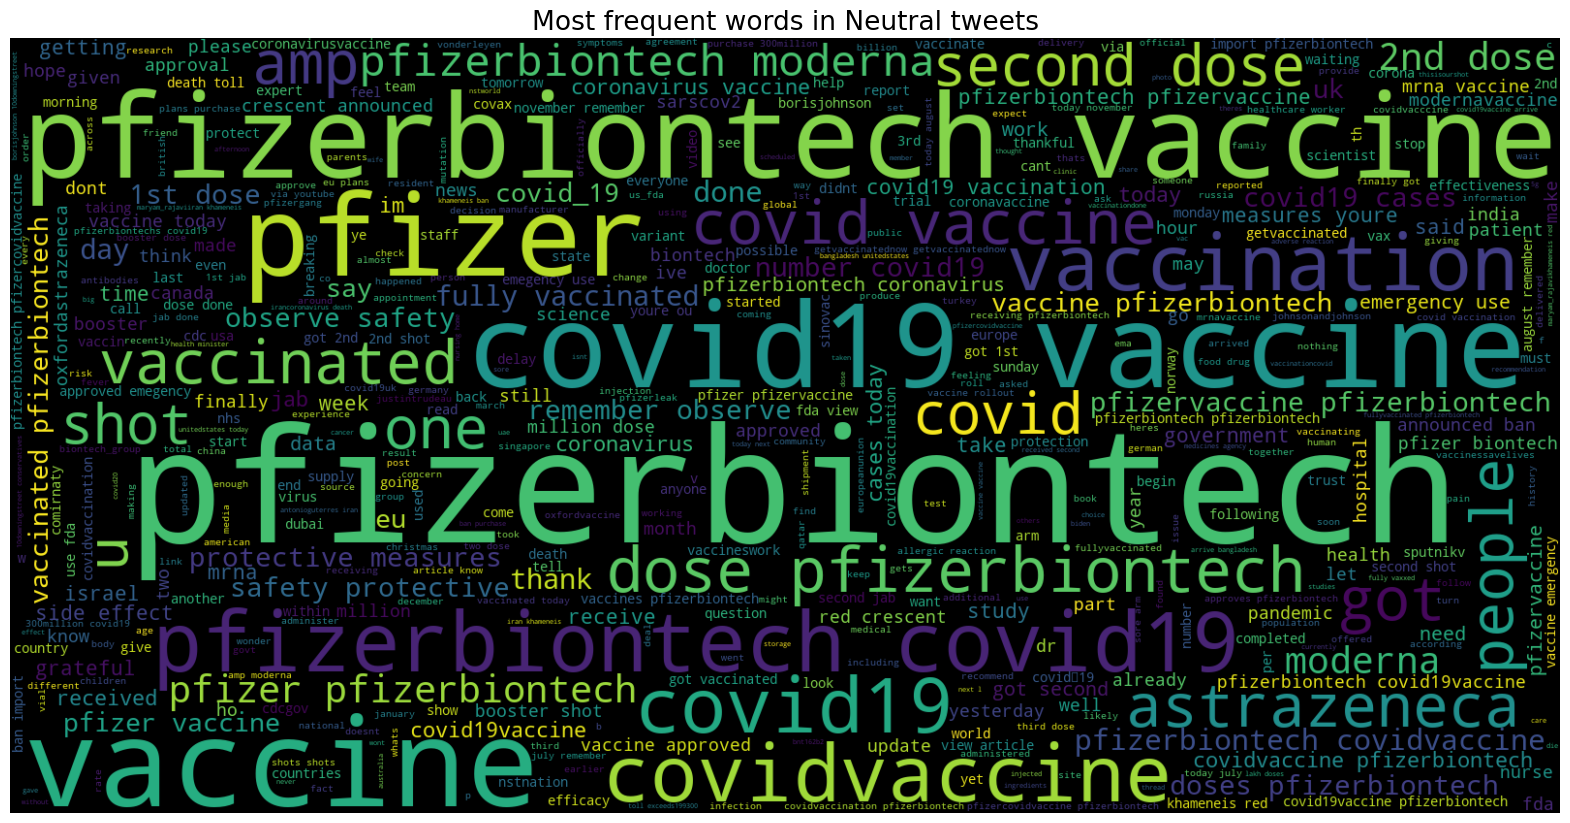

In [116]:
neu_tweets = text_dt[text_dt['sentiment']=='NEUTRAL']
neu_tweets = neu_tweets.sort_values(['polarity'],ascending=False)
text = ' '.join([word for word in neu_tweets['text']])
plt.figure(figsize=(20,15), facecolor="None")
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Neutral tweets',fontsize=19)
plt.show()

# FOR CONVERSION OF TEXT DATA INTO NUMERIC FORMAT.

In [117]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_dt['text'])

# DIVIDING FEATURES INTO DEPENDENT AND INDEPENDENT.

In [118]:
x = text_dt["text"]
y = text_dt["sentiment"]
x = vect.transform(x)

# SPLITTING DATA INTO TRAINING AND TESTING.

In [119]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# CREATING OBJECT FOR LOGISTIC REGRESSION & FITTING.

In [120]:
l_reg = LogisticRegression()
l_reg.fit(x_train,y_train)

LogisticRegression()

# PREDICTION FOR TEXT DATA

In [121]:
y_pred = l_reg.predict(x_test)

# FINDING ACCURACY

In [122]:
accr = accuracy_score(y_pred,y_test)
print("Accuracy is: ",accr*100)

Accuracy is:  85.2087114337568


# PLOTTING CONFUSION MATRIX

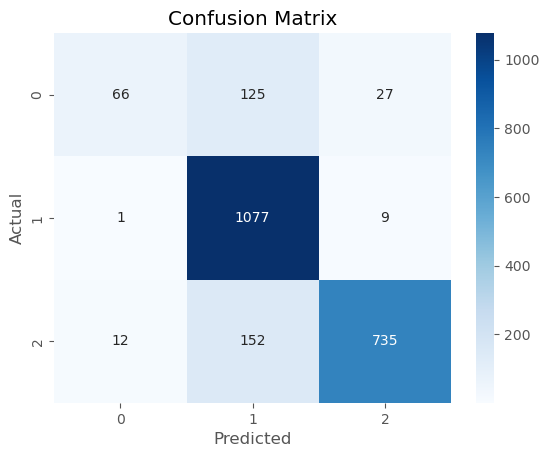

In [123]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# CLASSIFICATION REPORT.

In [124]:
cr = classification_report(y_pred,y_test)
print("Classification Report is: \n",cr)

Classification Report is: 
               precision    recall  f1-score   support

    NEGATIVE       0.30      0.84      0.44        79
     NEUTRAL       0.99      0.80      0.88      1354
    POSITIVE       0.82      0.95      0.88       771

    accuracy                           0.85      2204
   macro avg       0.70      0.86      0.74      2204
weighted avg       0.91      0.85      0.87      2204



# PREDICTING SENTIMENTS FOR USER REVIEW.

In [136]:
text = input("Enter your Review: ")
text_pp = data_preprocessing(text)
text_stem = stemming(text_pp)
pol_text = polarity(text_stem)
resultant_sentiment = sentiment(pol_text)
print("REVIEW ENTERED: \n",text)
print("Sentiment is: ",resultant_sentiment)

Enter your Review: THANK YOU.
REVIEW ENTERED: 
 THANK YOU.
Sentiment is:  NEUTRAL
